<a href="https://colab.research.google.com/github/possakorn/UoA_DL_2023_3_PK/blob/main/Assignment02_v4.0.0_cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment 2: CNNs for image classification

## Setup: import lib

In [32]:
## section: Data manioulation
import math
import pandas as pd
import numpy as np
import random
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## section: neural network
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR

from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

In [33]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
  worker = 4
else:
  worker = 0
print('Using device:', device, 'Using number of workers: ', worker)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Set the seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

Using device: cuda Using number of workers:  4

Tesla V100-SXM2-16GB
Memory Usage:
Allocated: 1.2 GB
Cached:    1.6 GB


## Step01: Data exploration

In [34]:
## Download from cifar10
dataset = 'cifar100' # change this one
set_seed(1311)
training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download = True,
    transform= transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

testing_data = datasets.CIFAR100(
    root="data",
    train=False,
    download = True,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

Files already downloaded and verified
Files already downloaded and verified


### Exploratory Image analysis

Check Shape of images:  torch.Size([3, 32, 32]) 11
Preview Images with Label : apple
Show of images unique 100 labels:  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank',

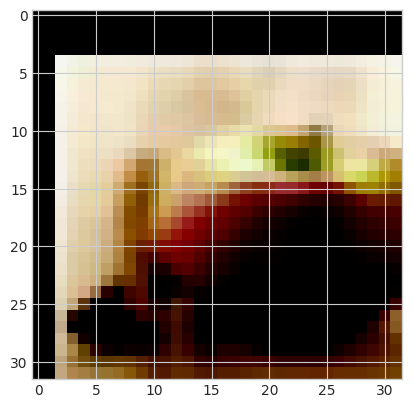

In [35]:
## check shape and labels
img, label = training_data[3]
print("Check Shape of images: ",img.shape,label)

def display_img(img,label):
  print(f"Preview Images with Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

#Show all labels
classes = training_data.classes
num_class = len(classes)
print(f"Show of images unique {num_class} labels: ",classes)


### Tranforms to Dataloader

In [36]:
training_data

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [37]:
batch_size = 16

## setting the split configuration
set_seed(1311)
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size
training_data, val_data = random_split(training_data, [train_size, val_size])

## apply the dataloader
set_seed(1311)

trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=worker,
    pin_memory = True
    )
valloader = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=worker,
    pin_memory = True
    )
testloader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=worker,
    pin_memory = True
    )

# check the splitting
num_items_train = len(trainloader.dataset)
num_items_val = len(valloader.dataset)
num_items_test = len(testloader.dataset)

num_batches_train = len(trainloader)
num_batches_val = len(valloader)
num_batches_test = len(testloader)

print("Training set: {} items, {} batches".format(num_items_train, num_batches_train))
print("Validation set: {} items, {} batches".format(num_items_val, num_batches_val))
print("Test set: {} items, {} batches".format(num_items_test, num_batches_test))

Training set: 40000 items, 2500 batches
Validation set: 10000 items, 625 batches
Test set: 10000 items, 625 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### check test set classes distribution

In [38]:
from collections import Counter

# Assuming testing_data is your test dataset
test_labels = [label for _, label in testing_data]

# Count the occurrences of each class
class_distribution = Counter(test_labels)

# Print the distribution
total_samples = sum(class_distribution.values())
for class_id, count in class_distribution.items():
    percentage = (count / total_samples) * 100
    print(f'Class {classes[class_id]}: {count} samples, {percentage:.2f}% of the test set')

Class mountain: 100 samples, 1.00% of the test set
Class forest: 100 samples, 1.00% of the test set
Class seal: 100 samples, 1.00% of the test set
Class mushroom: 100 samples, 1.00% of the test set
Class sea: 100 samples, 1.00% of the test set
Class tulip: 100 samples, 1.00% of the test set
Class camel: 100 samples, 1.00% of the test set
Class butterfly: 100 samples, 1.00% of the test set
Class cloud: 100 samples, 1.00% of the test set
Class apple: 100 samples, 1.00% of the test set
Class skunk: 100 samples, 1.00% of the test set
Class streetcar: 100 samples, 1.00% of the test set
Class rocket: 100 samples, 1.00% of the test set
Class lamp: 100 samples, 1.00% of the test set
Class lion: 100 samples, 1.00% of the test set
Class wolf: 100 samples, 1.00% of the test set
Class rose: 100 samples, 1.00% of the test set
Class orange: 100 samples, 1.00% of the test set
Class dinosaur: 100 samples, 1.00% of the test set
Class chimpanzee: 100 samples, 1.00% of the test set
Class can: 100 samples

### Review the Batch fig and size

torch.Size([16, 3, 32, 32])


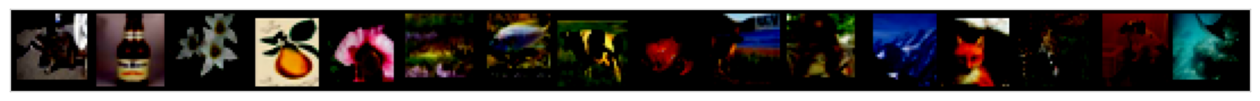

In [39]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

## show the batch fig
show_batch(trainloader)

## print the size
for batch in trainloader:
    print(batch[0].shape)  # Assuming batch[0] contains the data and batch[1] contains the labels
    break

## Base Model Functions For Image Classification

In [40]:
import time
from tqdm import tqdm

def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(trainloader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels.data)
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    epoch_acc = correct_train.double() / total_train
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device, num_class, class_eva = False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_class))
    class_total = list(0. for i in range(num_class))

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
            if class_eva:
                c = (preds == labels).squeeze()
                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

    loss = running_loss / total
    accuracy = correct.double() / total

    if class_eva:
        return loss, accuracy, class_correct, class_total
    else:
        return loss, accuracy

def evaluate(model, dataloader, criterion, device, num_class, class_eva=False, store_examples=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_class))
    class_total = list(0. for i in range(num_class))

    best_correct = None
    worst_incorrect = None

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

            if store_examples:
                probabilities = F.softmax(outputs, dim=1)
                for i in range(inputs.size(0)):
                    confidence, predicted_label = torch.max(probabilities[i], 0)
                    actual_label = labels[i].item()
                    if predicted_label.item() == actual_label:
                        if best_correct is None or confidence > best_correct['confidence']:
                            best_correct = {
                                'confidence': confidence,
                                'image': inputs[i],
                                'label': actual_label,
                            }
                    else:
                        if worst_incorrect is None or confidence < worst_incorrect['confidence']:
                            worst_incorrect = {
                                'confidence': confidence,
                                'image': inputs[i],
                                'label': actual_label,
                                'predicted_label': predicted_label.item(),
                            }

            if class_eva:
                c = (preds == labels).squeeze()
                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

    loss = running_loss / total
    accuracy = correct.double() / total

    results = (loss, accuracy)
    if class_eva:
        results += (class_correct, class_total)
    if store_examples:
        results += (best_correct, worst_incorrect)

    return results

# def display_image(image):
#     # Convert the image tensor to numpy and transpose the dimensions from (C, H, W) to (H, W, C)
#     image = image.cpu().numpy().transpose(1, 2, 0)
#     # Display the image
#     plt.imshow(image)
#     plt.show()

def display_image(image):
    if isinstance(image, dict):
        image = image['image']
    image = image.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(image)
    plt.show()

def train_network(model, optimizer, criterion, scheduler, trainloader, valloader, testloader, num_epochs, device, num_class, model_name, dataset):

    ## section00: setting path for save the model
    set_seed(1311)
    PATH = f'./{dataset}_{model_name}.pth'
    print('Model will be saved to:', PATH)
    print('Using device:', device, 'with seed: 1311')
    print()

    ## section01: Initialize variables
    best_val_acc = 0  # to track the best validation accuracy
    # create set to collect the output
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'best_correct': [],
        'worst_incorrect': [],
    }
    class_correct = list(0. for i in range(num_class))
    class_total = list(0. for i in range(num_class))

    ## section02: Training and validation the model
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, valloader, criterion, device, num_class)


        # Step the scheduler with the validation loss
        scheduler.step()
        # scheduler.step(val_acc) # for ReduceLROnPlateau

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(100 * train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(100 * val_acc)

        # Save the model if it has improved on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), PATH)
            print(f'Model improved and saved to {PATH}')

        # print epoch results
        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {100 * train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {100 * val_acc:.2f}%, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')

    print('Training complete. Evaluating on test set with the best model...')

    ## section03: Load the best model for final evaluation on test set
    best_model = model
    best_model.load_state_dict(torch.load(PATH))

    test_loss, test_acc, class_correct, class_total = evaluate(best_model, testloader, criterion, device, num_class, class_eva=True)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {100 * test_acc:.2f}%')
    # Add test results to history
    history['test_loss'] = test_loss
    history['test_accuracy'] = 100 * test_acc

    ## section04: Load the best model for final evaluation on test set for each class
    print(f'Test Acc on each class')
    class_results = {}
    for i in range(num_class):
        if class_total[i] > 0:
            results = 100 * class_correct[i] / class_total[i]
            class_results[classes[i]] = results
            print('Accuracy of class %s : %2d %%' % (classes[i], results))
        else:
            class_results[classes[i]] = 0
            print('Accuracy of class %s : N/A (no samples in test set)' % classes[i])

    history['class_results'] = class_results

    ## section04: collect the best and worst image
    test_loss, test_acc, best_correct, worst_incorrect = evaluate(
        best_model,
        testloader,
        criterion,
        device,
        num_class,
        class_eva=False,
        store_examples=True
    )
    history['best_correct'].append(best_correct)
    history['worst_incorrect'].append(worst_incorrect)
    print('Best Correct Prediction:')
    print('Confidence:', best_correct['confidence'].item())
    # print('Label:', int(best_correct['label']))
    print('Index:',  int(best_correct['label']), "- Labels: ",classes[int(best_correct['label'])])
    display_image(best_correct['image'])

    print('\nWorst Incorrect Prediction:')
    print('Confidence:', worst_incorrect['confidence'].item())
    print('Actual Index:', int(worst_incorrect['label']), "- Labels: ",classes[int(worst_incorrect['label'])])
    print('Predicted Index:', int(worst_incorrect['predicted_label']), "- Labels: ",classes[int(worst_incorrect['predicted_label'])])
    display_image(worst_incorrect['image'])

    return history

## Initialize network

### network: VGG19

In [41]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
          512, 512, 512, 512, 'M'],
}


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn():
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

### network: Alexnet

In [42]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_class):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



### network: ResNet18

In [43]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3, stride=stride, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=3,stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=num_class):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

## Train the network

In [44]:
def plot_loss(train_loss, val_loss):
    if isinstance(train_loss[0], torch.Tensor):
        train_loss = [x.cpu().numpy() for x in train_loss]
    if isinstance(val_loss[0], torch.Tensor):
        val_loss = [x.cpu().numpy() for x in val_loss]

    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

def plot_acc(train_acc, val_acc):
    if isinstance(train_acc[0], torch.Tensor):
        train_acc = [x.cpu().numpy() for x in train_acc]
    if isinstance(val_acc[0], torch.Tensor):
        val_acc = [x.cpu().numpy() for x in val_acc]

    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

In [45]:
# set the whole network training
num_epochs = 1
criterion = nn.CrossEntropyLoss()

### Check number of parameter

In [46]:
from torchsummary import summary
for i in [AlexNet(), vgg19(), ResNet18(), ResNet34(), ResNet50()]:
    print("Model: ", i.__class__.__name__)
    print("Number of parameters: ", sum(p.numel() for p in i.parameters() if p.requires_grad))
    summary(i.to(device), (3, 32, 32))
    print("-"*50)

Model:  AlexNet
Number of parameters:  57195428
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 192, 16, 16]         110,784
              ReLU-5          [-1, 192, 16, 16]               0
         MaxPool2d-6            [-1, 192, 8, 8]               0
            Conv2d-7            [-1, 384, 8, 8]         663,936
              ReLU-8            [-1, 384, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         884,992
             ReLU-10            [-1, 256, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         590,080
             ReLU-12            [-1, 256, 8, 8]               0
        MaxPool2d-13            [-1, 256, 4, 4]        

### Train the network - Alexnet

Model will be saved to: ./cifar100_alexnet.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 625/625 [00:05<00:00, 120.06it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 1/1, Train Loss: 4.6055, Train Acc: 0.96%, Val Loss: 4.6055, Val Acc: 0.86%, Time: 35.47s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 100.26it/s]


Test Loss: 4.6050, Test Acc: 1.00%
Test Acc on each class
Accuracy of class apple :  0 %
Accuracy of class aquarium_fish :  0 %
Accuracy of class baby :  0 %
Accuracy of class bear :  0 %
Accuracy of class beaver :  0 %
Accuracy of class bed :  0 %
Accuracy of class bee :  0 %
Accuracy of class beetle :  0 %
Accuracy of class bicycle :  0 %
Accuracy of class bottle :  0 %
Accuracy of class bowl :  0 %
Accuracy of class boy :  0 %
Accuracy of class bridge :  0 %
Accuracy of class bus :  0 %
Accuracy of class butterfly :  0 %
Accuracy of class camel :  0 %
Accuracy of class can :  0 %
Accuracy of class castle :  0 %
Accuracy of class caterpillar :  0 %
Accuracy of class cattle :  0 %
Accuracy of class chair :  0 %
Accuracy of class chimpanzee :  0 %
Accuracy of class clock :  0 %
Accuracy of class cloud :  0 %
Accuracy of class cockroach :  0 %
Accuracy of class couch :  0 %
Accuracy of class crab :  0 %
Accuracy of class crocodile :  0 %
Accuracy of class cup :  0 %
Accuracy of class di

Evaluating: 100%|██████████| 625/625 [00:07<00:00, 86.06it/s]


Best Correct Prediction:
Confidence: 0.010242830030620098
Index: 77 - Labels:  snail


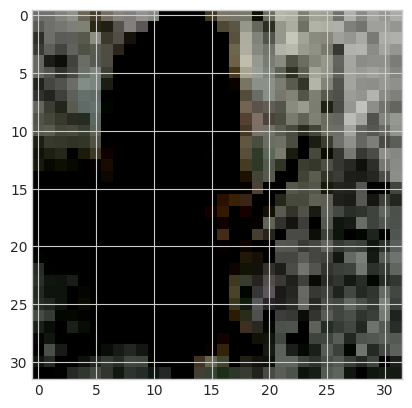


Worst Incorrect Prediction:
Confidence: 0.010229106061160564
Actual Index: 54 - Labels:  orchid
Predicted Index: 77 - Labels:  snail


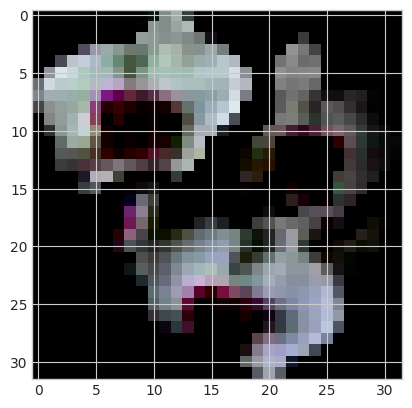

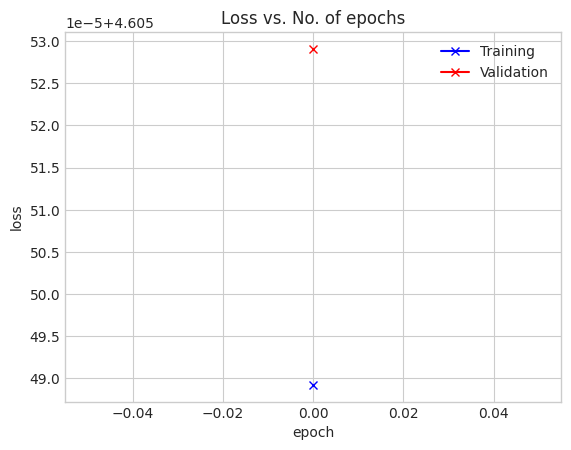

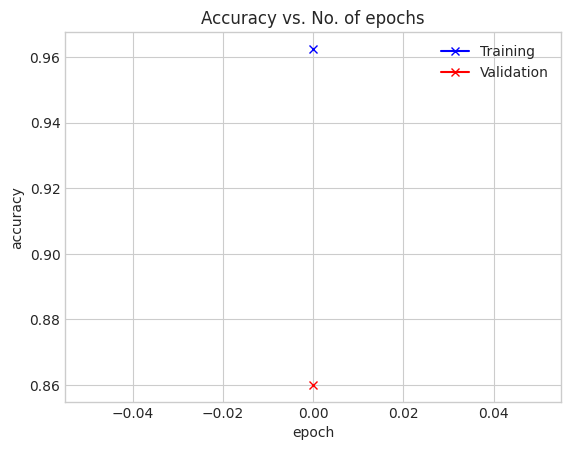

Test Loss: 4.6050, Test Accuracy: 1.00%


In [47]:
# individual configuration
alexnet = AlexNet().to(device)
model_name = "alexnet"
model = alexnet

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)


# training model
alexnet_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(alexnet_results['train_loss'], alexnet_results['val_loss'])
plot_acc(alexnet_results['train_accuracy'], alexnet_results['val_accuracy'])
# Print Test Loss and Test Accuracy

print(f'Test Loss: {alexnet_results["test_loss"]:.4f}, Test Accuracy: {alexnet_results["test_accuracy"]:.2f}%')

### Train the network - VGG19

In [49]:
# individual configuration
vggnet19 = vgg19().to(device)
model_name = "vggnet19"
model = vggnet19

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
vggnet19_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(vggnet19_results['train_loss'], vggnet19_results['val_loss'])
plot_acc(vggnet19_results['train_accuracy'], vggnet19_results['val_accuracy'])

RuntimeError: ignored

### Train the network - Resnet18

In [ ]:
# individual configuration
resnet18 = ResNet18().to(device)
model_name = "resnet18"
model = resnet18

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet18_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(resnet18_results['train_loss'], resnet18_results['val_loss'])
plot_acc(resnet18_results['train_accuracy'], resnet18_results['val_accuracy'])

### Train the network - Resnet34

In [ ]:
# individual configuration
resnet34 = ResNet34().to(device)
model_name = "resnet34"
model = resnet34

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet34_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )


# Plot the results
plot_loss(resnet34_results['train_loss'], resnet34_results['val_loss'])
plot_acc(resnet34_results['train_accuracy'], resnet34_results['val_accuracy'])

### Train the network - Resnet50

In [ ]:
# individual configuration
resnet50 = ResNet50().to(device)
model_name = "resnet50"
model = resnet50

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet50_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(resnet50_results['train_loss'], resnet50_results['val_loss'])
plot_acc(resnet50_results['train_accuracy'], resnet50_results['val_accuracy'])

## compare the accuracy on each class for each model

<ipython-input-50-64b556d95440>:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


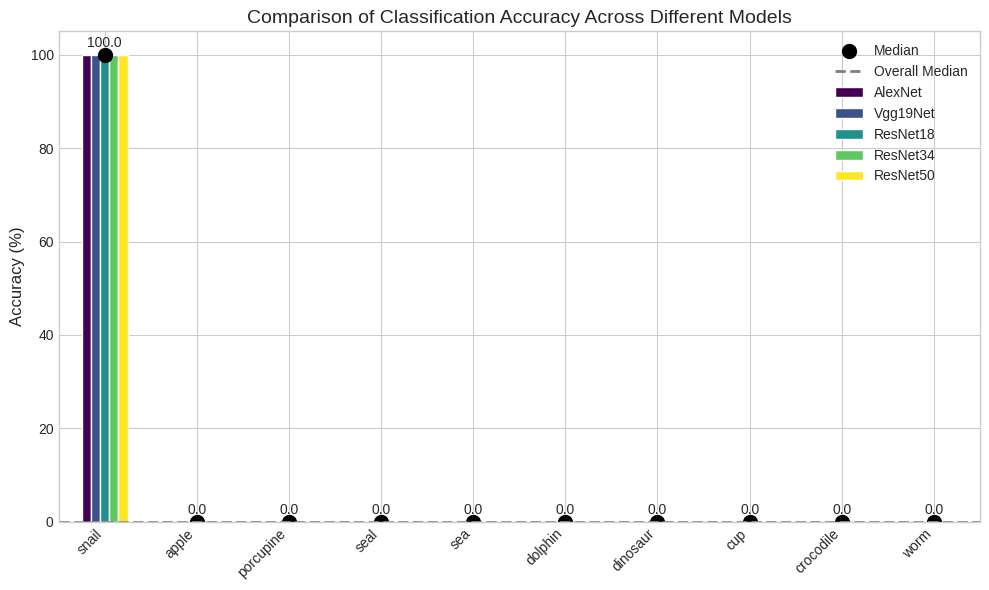

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compare_models(class_results_dict):
    # Create a DataFrame from the dictionary of class results
    df = pd.DataFrame(class_results_dict)

    # Calculate the median for all results
    df['Median'] = df.median(axis=1)

    # Sort the dataframe based on the median values
    df = df.sort_values(by='Median', ascending=False)

    # Select the best 5 and worst 5 classes
    best_5 = df.head(5)
    worst_5 = df.tail(5)

    # Combine best 5 and worst 5
    selected_classes = pd.concat([best_5, worst_5])

    # Plotting
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar plot for models
    colors = plt.cm.viridis(np.linspace(0, 1, len(class_results_dict)))
    selected_classes.drop(columns='Median').plot(kind='bar', ax=ax, color=colors)

    # Scatter plot for median values
    x_values = np.arange(len(selected_classes))
    ax.scatter(x_values, selected_classes['Median'], color='black', s=100, label='Median')

    # Horizontal line for overall median
    overall_median = df['Median'].median()
    ax.axhline(overall_median, color='gray', linewidth=2, linestyle='--', label='Overall Median')

    # Annotating the median values on the chart
    for i, value in enumerate(selected_classes['Median']):
        ax.text(i, value+1, f'{value:.1f}', ha='center', va='bottom', fontsize=10)

    # Setting labels and title
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Comparison of Classification Accuracy Across Different Models', fontsize=14)
    ax.legend()

    # Setting x-ticks
    ax.set_xticks(np.arange(len(selected_classes)))
    ax.set_xticklabels(selected_classes.index, rotation=45, ha='right', fontsize=10)

    # Show plot
    plt.tight_layout()
    plt.show()

# Example class results
class_results_dict = {
    'AlexNet': alexnet_results['class_results'],
    'Vgg19Net': vggnet19_results['class_results'],
    'ResNet18': resnet18_results['class_results'],
    'ResNet34': resnet34_results['class_results'],
    'ResNet50': resnet50_results['class_results']
}

# Compare the models
compare_models(class_results_dict)

## compare the best image and worst confident on each class for each model

RuntimeError: ignored

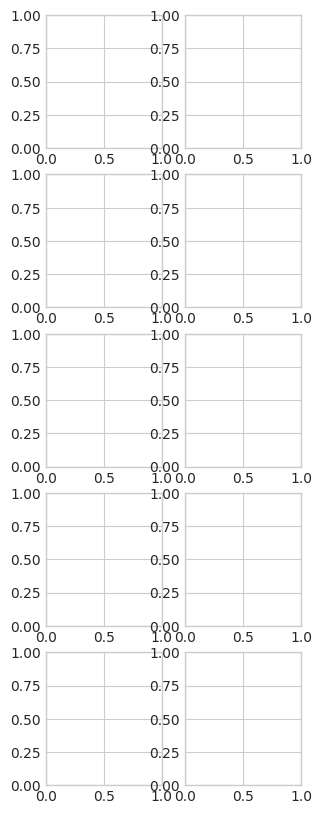

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_best_worst_predictions(model_histories, classes):
    # Set the style for the plot
    sns.set_style("whitegrid")

    num_models = len(model_histories)
    fig, axs = plt.subplots(num_models, 2, figsize=(10, 5 * num_models))

    for i, (model_name, results) in enumerate(model_histories.items()):
        # Best Prediction
        best_correct = results['best_correct'][0]
        image = best_correct['image'].cpu().numpy().transpose(1, 2, 0)
        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f"Best Prediction - {model_name} \n(Confidence: {best_correct['confidence'].item():.2f}, Label: {classes[best_correct['label']]})", fontsize=12)
        axs[i, 0].axis('off')

        # Worst Prediction
        worst_incorrect = results['worst_incorrect'][0]
        image = worst_incorrect['image'].cpu().numpy().transpose(1, 2, 0)
        axs[i, 1].imshow(image)
        axs[i, 1].set_title(f"Worst Prediction - {model_name} \n(Confidence: {worst_incorrect['confidence'].item():.2f}, Actual: {classes[worst_incorrect['label']]}, Predicted: {classes[worst_incorrect['predicted_label']]})", fontsize=12)
        axs[i, 1].axis('off')

    # Adding labels and title
    fig.text(0.04, 0.5, 'Models', va='center', rotation='vertical', fontsize=14)
    fig.text(0.5, 0.04, 'Predictions', ha='center', fontsize=14)
    plt.suptitle('Best and Worst Predictions Across Models', fontsize=16, y=1.02)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, wspace=0.1, hspace=0.4)

    plt.show()

def plot_best_worst_predictions(model_histories, classes):
    sns.set_style("whitegrid")

    num_models = len(model_histories)
    fig_width = 3.3  # inches
    fig_height = 2 * num_models  # Adjust the height based on the number of models
    fig, axs = plt.subplots(num_models, 2, figsize=(fig_width, fig_height))

    for i, (model_name, results) in enumerate(model_histories.items()):
        # Best Prediction
        best_correct = results['best_correct'][0]
        image = best_correct['image'].cpu().numpy().transpose(1, 2, 0)
        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f"Best - {model_name} \nConfidence: {best_correct['confidence'].item():.2f}, \nLabel: {classes[best_correct['label']]}", fontsize=8)
        axs[i, 0].axis('off')

        # Worst Prediction
        worst_incorrect = results['worst_incorrect'][0]
        image = worst_incorrect['image'].cpu().numpy().transpose(1, 2, 0)
        axs[i, 1].imshow(image)
        axs[i, 1].set_title(f"Worst - {model_name} \nConfidence: {worst_incorrect['confidence'].item():.2f}, \nLabel: {classes[worst_incorrect['label']]}", fontsize=8)
        axs[i, 1].axis('off')

    # Adding labels and title
    fig.text(0.04, 0.5, 'Models', va='center', rotation='vertical', fontsize=9)
    # plt.suptitle('Best and Worst Predictions', fontsize=10, y=1.02)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, wspace=0.2, hspace=0.05)

    plt.show()

# Assuming model_results_1, model_results_2, and model_results_3 are dictionaries that hold the results from different models
model_histories = {
    'AlexNet': alexnet_results,
    'Vgg19Net': vggnet19_results,
    'ResNet18': resnet18_results,
    'ResNet34': resnet34_results,
    'ResNet50': resnet50_results
}
plot_best_worst_predictions(model_histories, classes)